In [5]:
%pip install --upgrade openai --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
from openai import OpenAI 
import os

## Set the API key and model name
MODEL="gpt-4o"
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", ""))

In [ ]:
completion = client.chat.completions.create(
  model=MODEL,
  messages=[
    {"role": "system", "content": "You are a helpful assistant. Help me with my math homework!"}, # <-- This is the system message that provides context to the model
    {"role": "user", "content": "Hello! Could you solve 94*121?"}  # <-- This is the user message for which the model will generate a response
  ]
)

print("Assistant: " + completion.choices[0].message.content)

# Image

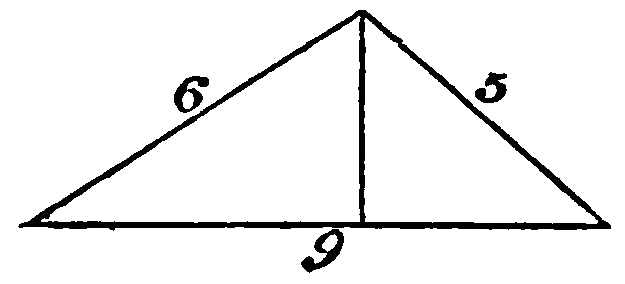

In [6]:
from IPython.display import Image, display, Audio, Markdown
import base64

IMAGE_PATH = "./data/triangle.png"

# Preview image for context
display(Image(IMAGE_PATH))

# Base64 Image Processing

In [ ]:
# Open the image file and encode it as a base64 string
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

base64_image = encode_image(IMAGE_PATH)

response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a helpful assistant that responds in Markdown. Help me with my math homework!"},
        {"role": "user", "content": [
            {"type": "text", "text": "What's the area of the triangle?"},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{base64_image}"}
            }
        ]}
    ],
    temperature=0.0,
)

print(response.choices[0].message.content)

# URL Image Processing

In [ ]:
response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a helpful assistant that responds in Markdown. Help me with my math homework!"},
        {"role": "user", "content": [
            {"type": "text", "text": "What's the area of the triangle?"},
            {"type": "image_url", "image_url": {
                "url": "https://upload.wikimedia.org/wikipedia/commons/e/e2/The_Algebra_of_Mohammed_Ben_Musa_-_page_82b.png"}
            }
        ]}
    ],
    temperature=0.0,
)

print(response.choices[0].message.content)

# Video

In [8]:
%pip install opencv-python --quiet
%pip install moviepy --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
import cv2
from moviepy.editor import VideoFileClip
import time
import base64

# We'll be using the OpenAI DevDay Keynote Recap video. You can review the video here: https://www.youtube.com/watch?v=h02ti0Bl6zk
VIDEO_PATH = "data/keynote_recap.mp4"

# Splliting MP4 in frames and audio

In [ ]:
def process_video(video_path, seconds_per_frame=2):
    base64Frames = []
    base_video_path, _ = os.path.splitext(video_path)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    curr_frame=0

    # Loop through the video and extract frames at specified sampling rate
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    # Extract audio from video
    audio_path = f"{base_video_path}.mp3"
    clip = VideoFileClip(video_path)
    clip.audio.write_audiofile(audio_path, bitrate="32k")
    clip.audio.close()
    clip.close()

    print(f"Extracted {len(base64Frames)} frames")
    print(f"Extracted audio to {audio_path}")
    return base64Frames, audio_path

# Extract 1 frame per second. You can adjust the `seconds_per_frame` parameter to change the sampling rate
base64Frames, audio_path = process_video(VIDEO_PATH, seconds_per_frame=1)


In [ ]:
## Display the frames and audio for context
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
    time.sleep(0.025)

Audio(audio_path)

# Summarization

In [ ]:
# visual summary (video(frames) to text)
response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content": "You are generating a video summary. Please provide a summary of the video. Respond in Markdown."},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames)
        ],
    }
    ],
    temperature=0,
)
print(response.choices[0].message.content)

In [ ]:
# Audio Summary (audio to text)

# Transcribe the audio
transcription = client.audio.transcriptions.create(
    model="whisper-1",
    file=open(audio_path, "rb"),
)
## OPTIONAL: Uncomment the line below to print the transcription
#print("Transcript: ", transcription.text + "\n\n")

response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""You are generating a transcript summary. Create a summary of the provided transcription. Respond in Markdown."""},
    {"role": "user", "content": [
        {"type": "text", "text": f"The audio transcription is: {transcription.text}"}
        ],
    }
    ],
    temperature=0,
)
print(response.choices[0].message.content)

In [ ]:
# AudioVisual Summary ( mp4 to text)

## Generate a summary with visual and audio
response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""You are generating a video summary. Create a summary of the provided video and its transcript. Respond in Markdown"""},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames),
        {"type": "text", "text": f"The audio transcription is: {transcription.text}"}
        ],
    }
],
    temperature=0,
)
print(response.choices[0].message.content)

# Q&A

In [ ]:
QUESTION = "Question: Why did Sam Altman have an example about raising windows and turning the radio on?"

In [ ]:
qa_visual_response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content": "Use the video to answer the provided question. Respond in Markdown."},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames),
        QUESTION
        ],
    }
    ],
    temperature=0,
)
print("Visual QA:\n" + qa_visual_response.choices[0].message.content)

In [ ]:
qa_audio_response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""Use the transcription to answer the provided question. Respond in Markdown."""},
    {"role": "user", "content": f"The audio transcription is: {transcription.text}. \n\n {QUESTION}"},
    ],
    temperature=0,
)
print("Audio QA:\n" + qa_audio_response.choices[0].message.content)

In [ ]:
qa_both_response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""Use the video and transcription to answer the provided question."""},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames),
                        {"type": "text", "text": f"The audio transcription is: {transcription.text}"},
        QUESTION
        ],
    }
    ],
    temperature=0,
)
print("Both QA:\n" + qa_both_response.choices[0].message.content)